## Notes for next week:
* filter down json file
  * flatten the data
  * remove the retweets
  * save in format usable by nltk or scikit learn tools
* Scikit for text analysis 
* Answering the questions for exploration of data
* Decide an actual question to answer
  * Media and text in combination


1. How many are geo-tagged in syria
2. How many have pictures/videos?
3. Tweet dates, over what timeframe, and distrubtion? 
4. Counts of distinct words in the text
5. Explore the hashtags used (can maybe confirm how they were scraped in the first place and/or find other tags)
6. Identify the most influential users/posts

In [2]:
import pandas
import json
import ijson
import pprint
from itertools import islice

In [3]:
# set file path for tweets dataset
tweet_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets/tweets.json'


In [4]:
# read n number of json objects from the tweets dataset
def read_n_from_file(json_path, n_lines):
    data = []
    with open(json_path) as f:
        for line in islice(f, n_lines):
            data.append(json.loads(line))
        return(data)  

# get sample json objects 
sample_json_objects = read_n_from_file(tweet_path, 1)

# print sample
pprint.pprint(sample_json_objects)


[{'_id': {'$oid': '595e82d713bbf01307babbba'},
  'contributors': None,
  'coordinates': None,
  'created_at': {'$date': '2017-07-06T18:34:37.000Z'},
  'entities': {'hashtags': [{'indices': [79, 88], 'text': 'Basirhat'}],
               'symbols': [],
               'urls': [{'expanded_url': None,
                         'indices': [134, 134],
                         'url': ''}],
               'user_mentions': [{'id': 147994804,
                                  'id_str': '147994804',
                                  'indices': [3, 15],
                                  'name': 'Rishi Bagree 🇮🇳',
                                  'screen_name': 'rishibagree'},
                                 {'id': 37034483,
                                  'id_str': '37034483',
                                  'indices': [117, 122],
                                  'name': 'NDTV',
                                  'screen_name': 'ndtv'}]},
  'favorite_count': 0,
  'favorited': False,
  'filter_

In [7]:
# %%timeit
# get the total number of json objects in file 
# json objects must be stored per line, not in an arrary 
# file contains separate JSON object on each line.
def count_json_objects(json_path):
    count = 0
    with open(json_path) as file:
        for line in file: 
            count+=1
        return count

def count_json_objects_chunk(json_path, chuck):
    count = 0
    with open(json_path) as f:
        while True:
            next_n_lines = list(islice(f, chuck))
            if not next_n_lines:
                break
            for line in next_n_lines: 
                count += 1
        return count

# print total number of json objects
# count_json_objects(file_path)


In [8]:
# how to profile a specific function
# %lprun -f count_json_objects count_json_objects(json_path)

In [9]:
# get column names and types for nested json
def get_columns_types(dataframe):
    column_details = {}
    columns = dataframe.columns.values.tolist()
    for column in columns: 
        column_details[column] = type(dataframe[column].iat[0])
    return column_details


In [10]:
from pandas.io.json import json_normalize

# new line json streamer
def nljson_generator(json_path):
    with open(json_path) as file:
        for line in file: 
            yield json.loads(line)
        
# load json to dataframe
def json_normalize_dataframe(json_object):
    dataframe = json_normalize(json_object)
    return dataframe

# source code: https://towardsdatascience.com/flattening-json-objects-in-python-f5343c794b10
# flattens nested json
def flatten_json(json_object):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(json_object)
    return out


In [11]:
from pandas import ExcelWriter
# create sample excel file with n number of tweets 
# read from json file, normalize json, and create dataframe
# transpose dataframe and save each tweet into seperate excel tab
def json_tweets_xlsx_sample(json_path, excel_path, 
                             tweet_start=0, tweet_limit='all', 
                             normalize=False):
    tweet_list = []
    json_stream = nljson_generator(json_path)
    
    if tweet_limit == 'all':
        tweets = json_stream
    else:
        if isinstance(tweet_limit, int): 
            tweets = islice(json_stream, tweet_start, tweet_start+tweet_limit)
    
    for tweet in tweets: 
        if normalize:
            tweet_normalize = json_normalize_dataframe(tweet)
            tweet_object = tweet_normalize.transpose()
        else:
            tweet_object = pandas.Series(tweet)
        tweet_list.append(tweet_object)
            
    print("writing tweets")
    writer = ExcelWriter(excel_path)
    for n, tweet in enumerate(tweet_list):
        tweet.to_excel(writer,'tweet%s' % n)
    writer.save()

# json_tweets_xlsx_sample(tweet_path, output_path, tweet_limit=10, normalize=True)
# json_tweets_xlsx_sample(tweet_path, output_path, tweet_start=100000, tweet_limit=15)


In [14]:
# removes retweets 
def remove_retweets(json_path, output_json_path):
    json_stream = nljson_generator(json_path)
    with open(output_json_path, 'w', encoding='utf-8') as output:
        for tweet in json_stream:
            text = tweet['text']
            if text.startswith('RT'):
                continue
            else:
                json.dump(tweet, output)
                output.write("\n")

tweets_no_retweets_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets.json'
# remove_retweets(tweet_path, tweets_no_retweets_path)               

## How many are geo-tagged and where

In [15]:
# how many are geo-tagged
# load latitude and longitude into dataframe
json_stream = nljson_generator(tweets_no_retweets_path)
geo_count = 0
geo_coordinates = []
for tweet in json_stream:  
    geo = tweet['geo']
    if geo:
        geo_count += 1
        geo_coordinates.append(geo['coordinates'])
    else:
        continue

print(geo_count)

# create dataframe of geo coordinates
coordinates_df = pandas.DataFrame(geo_coordinates, columns=['lat', 'long'])
coordinates_df.head()


63396


,lat,long
0,31.3893,35.3612
1,31.3893,35.3612
2,33.4863,36.2988
3,31.3893,35.3612
4,31.3893,35.3612


In [16]:
coordinates_df_path = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets_geo.csv'
coordinates_df.to_csv(coordinates_df_path)

## Get location information from coodinates

In [63]:
# https://geopy.readthedocs.io/en/stable/#usage-with-pandas
import geopy.geocoders
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

list_of_ints = [ x for x in range(0,70000,250) ]
geolocator = Nominatim(user_agent="nn")
def geo_search(row):
    if row.name in list_of_ints:
        print(row.name)
    try:
        location = geolocator.reverse(row.lat, row.long, language='en', timeout=1)
    except Exception as e:
        print(e)
        return None
    if location:
        try:
            location = location.raw
            address = location['address']
        except Exception as e:
            return None
    return address

import requests
def reverse_geocode(row):
    if row.name in list_of_ints:
        print(row.name)
    result = {}
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={}'
    try:
        request = url.format(row.lat,row.long)
        data = requests.get(request).json()
        if len(data['results']) > 0:
            result = data['results'][0]
    except:
        print (row.lat,row.long)
        return result
    return result

# testing = coordinates_df[0:200]
# testing['address'] = testing.apply(lambda row: geo_search(row), axis=1)
# testing.to_csv('/Users/adamstueckrath/Desktop/test.csv')

# coordinates_df['address'] = coordinates_df.apply(lambda row: geo_search(row), axis=1)
# coordinates_df_pathv2 = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets_geov2.csv'
# coordinates_df.to_csv(coordinates_df_pathv2)


## Collect tweet datetimes

In [80]:
# get information about dates of tweets
# https://stackoverflow.com/questions/6217056/twitter-timezone-created-at-utc-time-values-to-calculate-what-time-zone-the
import csv
tweet_dates_csv = '/Users/adamstueckrath/Desktop/twitter_data/tweets_no_retweets/tweets_no_retweets_dates.csv'
json_stream = nljson_generator(tweets_no_retweets_path)
with open(tweet_dates, mode='w') as csv_file:
    tweet_writer = csv.writer(csv_file, delimiter=',')            
    for tweet in json_stream:
        tweet_id = tweet['_id']['$oid']
        tweet_date = tweet['user']['created_at']
        utc_offset = tweet['user']['utc_offset']
        tweet_date_object = pandas.to_datetime(tweet_date)
        tweet_date_object_offset = tweet_date_object.tz_localize(utc_offset)
        tweet_writer.writerow([tweet_id, tweet_date_object, tweet_date_object_offset])

In [131]:
# load tweet dates into dataframe
tweet_dates_df = pandas.read_csv(tweet_dates_csv, sep=',', delimiter=None, 
                                 header=None, names=['id','created_at','created_at_offset'],
                                 parse_dates=['created_at', 'created_at_offset'])
tweet_dates_df.head()


,id,created_at,created_at_offset
0,595e82d713bbf01307babbbd,2010-04-23 16:47:40,2010-04-23 19:47:40
1,595e82d713bbf01307babbc0,2017-03-03 07:35:57,2017-03-03 10:35:57
2,595e82d713bbf01307babbc1,2017-03-03 07:35:57,2017-03-03 10:35:57
3,595e82d713bbf01307babbc6,2016-11-10 21:59:10,2016-11-11 00:59:10
4,595e82d713bbf01307babbc7,2017-03-03 07:35:57,2017-03-03 10:35:57


## Plot tweet counts over time

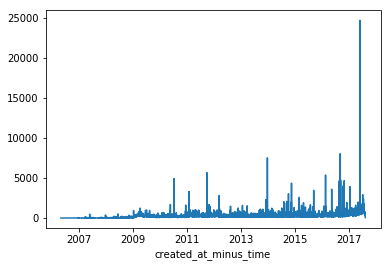

In [135]:

import datetime
%matplotlib inline
import matplotlib.pyplot as plt

tweet_dates_df['created_at_minus_time'] = tweet_dates_df["created_at"].apply(lambda df: datetime.datetime(year=df.year,
                                                                                                          month=df.month, 
                                                                                                          day=df.day))
# group tweet dates and counts
# plot over time
tweet_dates_group_df = tweet_dates_df['created_at_minus_time'].groupby([tweet_dates_df.created_at_minus_time.dt.date]).agg('count')
tweet_dates_group_df.plot(kind="line")

## Find unique hashtags and counts

In [ ]:
{'hashtags': [{'text': 'G20', 'indices': [21, 25]}, {'text': 'WelcomeToHell', 'indices': [26, 40]}, {'text': 'Hamburg', 'indices': [53, 61]}, {'text': 'Germany', 'indices': [62, 70]}, {'text': 'Syria', 'indices': [72, 78]}, {'text': 'Syrie', 'indices': [79, 85]}],

In [139]:
# find hashtags 
json_stream = nljson_generator(tweets_no_retweets_path)
counter = 0

for tweet in json_stream:
    tweet_hashtags = tweet['entities']['hashtags']
    if tweet_hashtags:
        for hashtag in tweet_hashtags:
            print (hashtag['text'])
    counter += 1
    if counter == 10:
        break
    else:
        continue

FAKENEWS
G20
WelcomeToHell
Hamburg
Germany
Syria
Syrie
world
